# Assignment - 2 : Modelling Exercise

**Heart Stroke Prediction**

Stroke prediction is like a proactive approach to healthcare, aiming to identify individuals at higher risk of stroke before it occurs. By analysing patient data, it can spot patterns and risk factors that indicate potential stroke incidents. Early identification helps healthcare professionals implement preventive measures, improving patient outcomes and reducing the burden of stroke-related disabilities.

I am a `Data Scientist` working in `Healthcare Analytics`. My role involves developing models that can assist healthcare professionals in identifying patients who are at higher risk of stroke, enabling early intervention and personalized care. Stroke is a leading cause of disability and death worldwide, and predicting it in advance can greatly improve patient health outcomes. The project aims to build a machine learning model using a stroke prediction dataset to assess the likelihood of stroke in patients based on various health and lifestyle factors, such as age, hypertension, heart disease, and smoking status.

The dataset used for this project is from Kaggle . This dataset includes patient details, such as age, gender, BMI, glucose levels, work-type, smoking status, hypertension and heart disease, making it suitable for developing a robust stroke prediction model.

## Data

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix



Now using pandas' read_csv, I loaded the data to `train_data` and `test_data` dataframes

In [81]:
# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/DushyanthReddy123/Assignment/refs/heads/main/healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


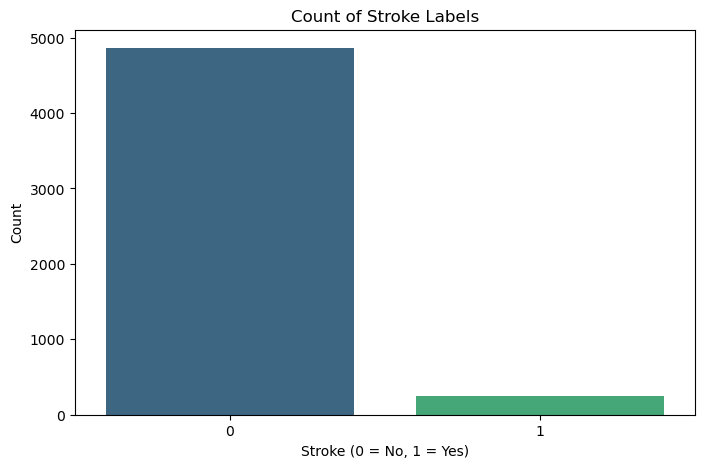

In [77]:
plt.figure(figsize=(8, 5))
sns.countplot(x="stroke", data=data, palette="viridis")  # Pass the full DataFrame to `data`, and specify `x="stroke"`
plt.title("Count of Stroke Labels")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

## Data Preprocessing and Feature Engineering

In [78]:
def assign_age_group(age):
    if age < 2:
        return 'infant'
    elif age <= 19:
        return 'child'
    elif age < 60:
        return 'adult'
    else:
        return 'senior'

data['age_group'] = data['age'].apply(assign_age_group)

In [79]:
# Check missing values
print(data.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_group              0
dtype: int64


In [64]:
# Impute missing BMI values by median within age group and gender
data['bmi'] = data.groupby(['age_group', 'gender'])['bmi'].transform(lambda x: x.fillna(x.median()))

In [65]:
# Drop ID column
data.drop('id', axis=1, inplace=True)
data.drop(index = data[data['gender']=='Other'].index[0] ,axis=0,inplace=True)
# Encode categorical variables
data = pd.get_dummies(data, columns=['age_group', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

In [66]:
# Define features and target
X = data.drop('stroke', axis=1)
y = data['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Balancing, Splitting and Scaling Data

In [67]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
X_train,X_test,y_train,y_test = train_test_split(X_over,y_over,test_size=0.3,stratify=y_over,random_state=42)

In [68]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## Model Training, Hyperparameter Tuning and Performance Evaluation

To predict stroke risk, I used and tuned the following models, each with three sets of hyperparameters:

**KNN**

Functions as a healthcare recommendation system by locating patients with similar profiles based on features like age, bmi, and hypertension. If many of these “neighbors” have had strokes, the model flags the current patient as high risk.

Capable of adapting to complex, non-linear relationships among risk factors without imposing fixed assumptions, making it well-suited for capturing localized patterns in stroke risk.



**Random Forest**

Operates like a team of diverse medical experts, where each “expert” (tree) assesses patient data from various perspectives and then combines predictions for a balanced, reliable output.

Effectively captures interactions between multiple health factors, offering insights into feature importance. This helps identify critical risk factors like age and avg_glucose_level, which can guide preventive care strategies.

### Hyperparameters 

I used GridSearchCV to perform an exhaustive search over specified hyperparameters, finding the best combinations to enhance model performance and ensure robust generalization. For K-Nearest Neighbors (KNN), I tuned n_neighbors, weights, and metric, while for Random Forest, I adjusted n_estimators, max_depth, and min_samples_split. These optimized hyperparameters helped improve model accuracy for stroke risk prediction.

In [69]:

# KNN hyperparameter tuning
knn_params = {
    'n_neighbors': list(range(3, 7)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

# Random Forest tuning
rf_params = {
    'n_estimators': [50, 75, 100, 150, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

**Evaluation Metrics**

Given the significant imbalance in the dataset, with approximately 5% stroke cases and 95% non-stroke cases, it’s crucial to use evaluation metrics that provide a balanced view of model performance:

•	Precision and Recall: With an imbalanced dataset, precision and recall are key metrics. Precision ensures that when the model predicts a stroke, it is accurate, minimizing false positives. Recall focuses on detecting actual stroke cases, ensuring that as many true positives are captured as possible.

•	F1 Score: The F1 score combines precision and recall into a single metric, making it particularly useful for imbalanced datasets like this one. It provides a balanced measure of the model’s ability to correctly identify stroke cases without being overly influenced by the majority class.

•	Accuracy: While accuracy gives an overall view of model performance, it can be misleading for imbalanced datasets. In this case, the model could achieve high accuracy just by predicting non-stroke for most cases. However, it’s still a useful measure to consider alongside more specific metrics.


In [70]:
# Model evaluation and preparing data for tabulation
evaluation_data = []

for model, name in zip([best_knn, best_rf], ['KNN', 'Random Forest']):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Get the best hyperparameters from GridSearchCV
    if name == 'KNN':
        best_params = knn_grid.best_params_
    elif name == 'Random Forest':
        best_params = rf_grid.best_params_
    
    # Add the results to the list for tabulation
    evaluation_data.append([name, accuracy, precision, recall, f1, str(best_params)])

In [71]:
# Define column names for the table
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Best Parameters"]

# Print the table using tabulate (adjust the format)
print(tabulate(evaluation_data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤═════════════╤══════════╤════════════╤══════════════════════════════════════════════════════════════════╕
│ Model         │   Accuracy │   Precision │   Recall │   F1 Score │ Best Parameters                                                  │
╞═══════════════╪════════════╪═════════════╪══════════╪════════════╪══════════════════════════════════════════════════════════════════╡
│ KNN           │   0.950617 │    0.910112 │        1 │   0.952941 │ {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} │
├───────────────┼────────────┼─────────────┼──────────┼────────────┼──────────────────────────────────────────────────────────────────┤
│ Random Forest │   0.988683 │    0.977867 │        1 │   0.98881  │ {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300} │
╘═══════════════╧════════════╧═════════════╧══════════╧════════════╧══════════════════════════════════════════════════════════════════╛



Classification Report for KNN:

Precision: 0.91
F1 Score: 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1458
           1       0.91      1.00      0.95      1458

    accuracy                           0.95      2916
   macro avg       0.96      0.95      0.95      2916
weighted avg       0.96      0.95      0.95      2916



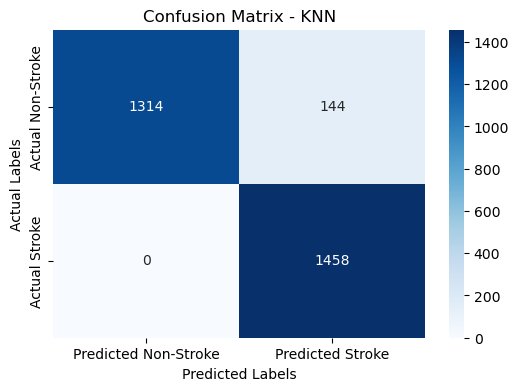


Classification Report for Random Forest:

Precision: 0.98
F1 Score: 0.99
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1458
           1       0.98      1.00      0.99      1458

    accuracy                           0.99      2916
   macro avg       0.99      0.99      0.99      2916
weighted avg       0.99      0.99      0.99      2916



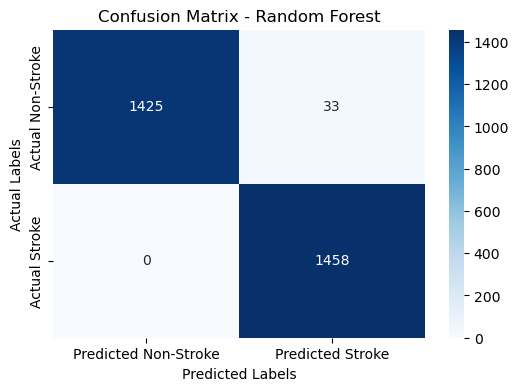

In [72]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Non-Stroke', 'Predicted Stroke'],
                yticklabels=['Actual Non-Stroke', 'Actual Stroke'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Print detailed classification report and confusion matrix for each model
for model, name in zip([best_knn, best_rf], ['KNN', 'Random Forest']):
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:\n")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)


## Conclusion

•Based on the results, the Random Forest model with optimal hyperparameters performed better than KNN for the given stroke prediction dataset. It achieved higher precision, recall, and F1 scores, making it a robust choice for identifying potential stroke cases accurately.

•	Currently, the model was tested on a dataset consisting of 250 stroke cases and 4750 non-stroke instances, showing reliable performance in detecting true positives and minimizing false negatives.

•	In the future, with more time or resources, apart from exploring advanced models like DNNs, I would consider further selecting the right dataset and also in improving the data preprocessing pipeline. This could include experimenting with additional features, better handling of class imbalance, and possibly using clustering techniques to identify hidden patterns before model implementation. Further hyperparameter tuning and ensembling different models could also be explored to enhance the f1 score of stroke prediction.
